### This notebook process the initial dataset, in order to extract usefull information from it. 

In this dataset there are trajectories from 181 users. Only 69 of them have labeled their trajectories as Taxi, Car, Bus , Train, Subway and Walk. We are interested only in vehicle trajectories labeled as <b>Taxi</b>, <b>Car</b> and <b>Bus</b>.

In [30]:
# measure execution time
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 15 ms (started: 2023-05-12 17:00:55 +03:00)


#### Delete all folders, which contain unlabeled trajectories. We keep only the trajectories that are labeled.

Prefered labels are: Car, Bus and Taxi.

In [18]:
import os
import shutil

# define the path in which data are stored
path = 'C:/Users/SK/Desktop/Πτυχιακή/Σύνολα Δεδομένων/Geolife Trajectories 1.3/Data'

# measure number of folders that remained after deletion
counter = 0 

for filename in os.listdir(path):
    if (os.path.isfile(path+'/'+filename+'/labels.txt') == False):
        shutil.rmtree(path+'/'+filename) # remove
    else:
        counter += 1 # keep remained folders in path

print("Number of remained folders is: ",counter)

Number of remained folders is:  69
time: 47 ms (started: 2023-05-12 16:34:59 +03:00)


In [19]:
import pandas as pd

for filename in os.listdir(path):
    # read the file labels.txt of each folder
    label = pd.read_csv(path+'/'+filename+'/labels.txt',sep='\t',names=['Start Time','End Time','Transportation Mode'])
    
    # keep only necessary labels
    label = label[(label['Transportation Mode'] == 'car') | (label['Transportation Mode'] == 'bus') | (label['Transportation Mode'] == 'taxi')]
    
    # save the new file with the same name in the same folder (file replacion with the necessary information only)
    path_to_be_saved = path+'/'+filename+'/labels.txt'
    label.to_csv(path_to_be_saved,index=False,sep='\t')

time: 1.58 s (started: 2023-05-12 16:35:03 +03:00)


#### Make the trajectory dataset
Add in a new dataframe only the information of the trajecotries that we are interested in. This information refers to:

-  <b>File ID:</b> The ID number of the folder, in which the information was teken.
-  <b>Latitude:</b> The latitude of the GPS point.
-  <b>Longitude:</b> The longitude of the GPS point.
-  <b>Date Time:</b> Timestamp, in which the GPS was recorded.
-  <b>Label:</b> This field contains one of the following values - Taxi, Bus or Car.

In [ ]:
# make empty dataframe, in which all the data used for our research will be saved
all_data = pd.DataFrame(columns = ['File ID','Latitude','Longitude','Date Time','Label']) 

id = 0 # trajectory ID

for directory in os.listdir(path):

    # read label.txt file of folder
    labels = pd.read_csv(path+'/'+directory+'/'+'labels.txt',sep='\t',names=['Start Time','End Time','Transportation Mode'],skiprows=[0])
    
    if (labels.shape[0] != 0):
        
        # temporary dataframe
        directory_data = pd.DataFrame(columns = ['File ID','Latitude','Longitude','Date Time','Label'])

        # convert datetime in labels.txt file to necessary format
        labels['Start Time'] = pd.to_datetime(labels['Start Time'],format='%Y-%m-%d %H:%M:%S.%f')
        labels['End Time'] = pd.to_datetime(labels['End Time'],format='%Y-%m-%d %H:%M:%S.%f')

        for filename in os.listdir(path+'/'+directory+'/'+'Trajectory'): # for each folder

            # read data file
            data = pd.read_csv(path+'/'+directory+'/'+'Trajectory'+'/'+filename,skiprows=[0,1,2,3,4,5],sep=',',names=['Latitude','Longitude','Field 0','Altitude','Days Passed','Date','Time'])

            # drop unecessary columns from data file
            data.drop(['Days Passed','Altitude','Field 0'],axis=1,inplace=True)

            # join time information to one column
            data['Date Time'] = data['Date']+' '+data['Time']
            data['Date Time'] = pd.to_datetime(data['Date Time'],format='%Y-%m-%d %H:%M:%S.%f')
            data.drop(['Date','Time'],axis=1,inplace=True)

            # add the ID of the trajectory
            data.insert(0,'File ID',id)

            directory_data = pd.concat([directory_data, data],ignore_index = True)
            
            id += 1
        
        # assign the label to each trajectory of the specific folder
        for y in range(labels.shape[0]):
            directory_data.loc[(directory_data['Date Time'] >= labels['Start Time'][y]) & (directory_data['Date Time'] <= labels['End Time'][y]),'Label'] = labels['Transportation Mode'][y] 
        
        directory_data.dropna(axis=0,inplace=True)
        
        all_data = pd.concat([all_data, directory_data],ignore_index = True)
        
        print("Files in folder "+str(directory)+" have been proccessed!")

#### Process the dataset

In this dataset, there are GPS information from many cities of China. The majority of those GPS records are located in the city of Beijing. We focus only in this information.

In [ ]:
# keep only GPS points from the city of Beijing
all_data = all_data[(all_data['Latitude'] >= 39.8) & (all_data['Longitude'] >= 116.1)]

In [ ]:
# add a new column, which indicates the ID of each trajectory
all_data.insert(1,'Traj ID',-1)

In [ ]:
# save the data to file
all_data.to_csv('C:/Users/SK/Desktop/Πτυχιακή/Σύνολα Δεδομένων/Geolife Trajectories 1.3/all_original.txt',index=False)

#### Split the trajectories based in time field and FIle ID

Split each trajectory in the same File ID based in the timestamp field.
Here, <b>n_sec</b> variable denotes the maximum number of seconds that each GPS record within a trajecotry should have.

In [ ]:
# convert timestamp field to datetime
all_data['Date Time'] = pd.to_datetime(all_data['Date Time'],format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
''' 
Each File ID contains GPS data of one trajectory

If the time gap between two GPS points is lower than n_sec seconds, (condition 1)
and these GPS points belong to the same File ID  (condition 2)
then asign the same Traj ID number. (result)

If the time gap between two GPS points is higher than n_sec seconds, (condition 1)
and these GPS points belong to the same File ID  (condition 2)
then asign different Traj ID number to each of these GPS points. (result)

If the GPS points belong to the same File ID  (condition 2)
then asign different Traj ID number to each of these GPS points. (result)

'''

# max number of seconds between GPS records of each traectory
n_sec = 15
traj_id = 0

for i in range(all_data.shape[0] -1):
    
    if (all_data['File ID'][i+1] == all_data['File ID'][i]): # belong to the same File ID
        
        if (((all_data['Date Time'][i+1])-(all_data['Date Time'][i])).total_seconds() <= n_sec): # time interval less-equal than n_sec
            all_data.at[i,'Traj ID'] = traj_id
            all_data.at[i+1,'Traj ID'] = traj_id
            
        else: # time interval higher than n_sec
            all_data.at[i,'Traj ID'] = traj_id
            traj_id +=1
            all_data.at[i+1,'Traj ID'] = traj_id
    
    else: # not belong to the same File ID
        all_data.at[i,'Traj ID'] = traj_id
        traj_id  = 0
        all_data.at[i+1,'Traj ID'] = traj_id

In [ ]:
# save data (with information of splitted trajectories)
all_data.to_csv('C:/Users/SK/Desktop/Πτυχιακή/Σύνολα Δεδομένων/Geolife Trajectories 1.3/all_broken_trajectories.txt',index=False)

### Process the dataset created in the previous code blocks. In particular, do the following:

-  Map Matching
- Visualization
- Creation of the Time Series dataset

In [31]:
# import libraries
import pandas as pd

import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns

import tqdm
from tqdm.notebook import tqdm_notebook

from datetime import datetime, timedelta

import json
import requests

%matplotlib inline

time: 0 ns (started: 2023-05-12 17:01:04 +03:00)


#### Delete the duplicate information contained in the columns File ID, Traj ID.

In [3]:
# read file
all_data = pd.read_csv('C:/Users/SK/Desktop/Πτυχιακή/Σύνολα Δεδομένων/Geolife Trajectories 1.3/all_broken_trajectories.txt',
                       skiprows=[0], names=['File ID','Traj ID','Latitude','Longitude','Date Time','Label'],low_memory=False)

# convert timestamp field to datetime
all_data['Date Time'] = pd.to_datetime(all_data['Date Time'],format='%Y-%m-%d %H:%M:%S.%f')

time: 31 ms (started: 2023-05-12 00:58:18 +03:00)


In [ ]:
# delete trajectories, which contain only one GPS point
unique_pairs = all_data.loc[:, ['File ID', 'Traj ID']].drop_duplicates(keep=False).index
all_data.drop(unique_pairs,axis=0,inplace=True)
all_data.reset_index(drop=True,inplace=True)

#### Begin Map Matching

Map matching done using Valhalla Meili API. Given each trajectory to the API as input, the response contains information of the exact path that each trajectory followed. The paths are OSM Way IDs. 

Sources:

-  <b>Installation using Docker: </b>https://ikespand.github.io/posts/meili/
-  <b>Paper about Valhalla: </b>https://link.springer.com/article/10.1007/s42979-022-01340-5#Tab5
-  <b>APIs documentation: </b>https://valhalla.github.io/valhalla/api/map-matching/api-reference/#matched-point-items  

In [6]:
# pass lat and lot pairs to Valhalla API
df_for_meili = all_data[['Latitude','Longitude']]
df_for_meili = df_for_meili.rename(columns={"Latitude": "lat", "Longitude": "lon"})

time: 15 ms (started: 2023-05-12 00:59:35 +03:00)


Create a new dataframe under the name "visited_segments", in which information about each trajectory will be contained. The columns of this new dataframe are:
-  <b>File ID: </b>The folder that contains information of this trajecotry.
-  <b>Traj ID: </b>The ID of the trajectory in this folder.
-  <b>OSM Way ID: </b>The way ID number of the edge that trajectory visited.
-  <b>Start Time: </b>Expected time that trajecotry enter the specific edge.
-  <b>End Time: <b>Expected time that trajecotry left the specific edge.

In [12]:
visited_segments = pd.DataFrame(columns=['File ID','Traj ID','OSM Way ID','Start Time','End Time','Label'])

for file_id in all_data['File ID'].unique():
    for traj_id in all_data[all_data['File ID'] == file_id]['Traj ID'].unique():
    
            # get the batch of data that we send to the request
            indexes = all_data[(all_data['File ID']==file_id) & (all_data['Traj ID'] == traj_id)].index
            
            # input to API
            passed_data = df_for_meili.iloc[indexes]
            
            # get label
            label = all_data.iloc[indexes].reset_index(drop=True).loc[0,'Label']
            
            # Preparing the request to Valhalla's Meili
            meili_coordinates = passed_data.to_json(orient='records')
            meili_head = '{"shape":'
            meili_tail = ""","search_radius": 250, "sigma_z": 10, "beta": 10,"shape_match":"map_snap", "costing":"auto",
                            "filters":{"attributes":["edge.way_id"],"action":"include"},
                            "format":"osrm"}"""
            
            # this is the request
            meili_request_body = meili_head + meili_coordinates + meili_tail

            # the URL of the local valhalla server
            url = "http://localhost:8002/trace_attributes"

            # providing headers to the request
            headers = {'Content-type': 'application/json'}

            # we need to send the JSON as a string
            data = str(meili_request_body)

            # sending a request
            r = requests.post(url, data=data, headers=headers)
            
           
            if r.status_code == 200: # response from Valhalla API was successful
                
                # Parsing the JSON response
                response_text = json.loads(r.text)
                
                # find the time interval (in sec) that the trajectory needs to be completed [last timestamp - first timestamp]
                interval = (all_data.iloc[indexes].iloc[-1]['Date Time'] - all_data.iloc[indexes].iloc[0]['Date Time']).total_seconds()
                
                # compute the expected duration that the moving object is in each edge (duration is equal for each edge that the trajectory visits)
                duration  = interval/len(response_text['edges'])
                
                # make a temporary dataframe
                temp = pd.DataFrame(columns=['File ID','Traj ID','OSM Way ID','Start Time','End Time','Label'])
                
                # make the final dataframe with the help of a temporary dataframe
                for i in range(len(response_text['edges'])):
                    
                    # complete the fields of temp dataframe
                    temp.at[i,'File ID'] = file_id
                    temp.at[i,'Traj ID'] = traj_id
                    temp.at[i,'OSM Way ID'] = response_text['edges'][i]['way_id']
                    
                    if i == 0:
                        temp.at[i,'Start Time'] = all_data.iloc[indexes].iloc[0]['Date Time']
                    else:
                        temp.at[i,'Start Time'] = temp.at[i-1,'End Time']
                        
                    temp.at[i,'End Time'] = temp.at[i,'Start Time'] + timedelta(seconds=duration)
                    
                    temp.at[i,'Label'] = label
                    
                # concatenate the two dataframes
                visited_segments = pd.concat([visited_segments,temp],ignore_index=True)

time: 15.1 s (started: 2023-05-12 01:03:27 +03:00)


In [ ]:
# delete trajectories, which contain only one OSM Way ID
uniques = visited_segments.loc[:, ['File ID', 'Traj ID']].drop_duplicates(keep=False).index
visited_segments.drop(uniques,axis=0,inplace=True)
visited_segments.reset_index(drop=True,inplace=True)

In [ ]:
# save the new dataframe
visited_segments.to_csv('C:/Users/SK/Desktop/Πτυχιακή/Σύνολα Δεδομένων/Geolife Trajectories 1.3/visited_segments.txt',index=False)

#### Visualization
We use some graphs, in order to have statistics of the results.

<Axes: xlabel='Label', ylabel='count'>

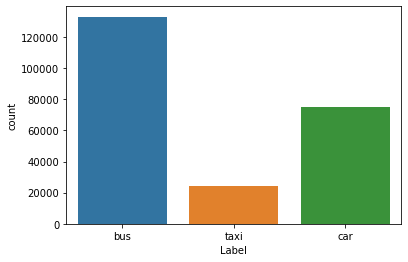

time: 750 ms (started: 2023-05-12 17:09:21 +03:00)


In [37]:
# count number of observations per Label in the new dataframe "visited_segments" (car, bus and taxi)
sns.countplot(data=visited_segments,x=visited_segments['Label'])

#### Find consequtive paths inside the visited_segments dataframe

A path consists of many edges that are consequtive between them. In order for a path to be valid, each consequtive number of edges should be extracted from a specific trajectory each time.

In [99]:
import pandas as pd

visited_segments = pd.read_csv('C:/Users/SK/Desktop/Πτυχιακή/Σύνολα Δεδομένων/Geolife Trajectories 1.3/visited_segments.txt',
                   skiprows=[0],names=['File ID','Traj ID','OSM Way ID','Start Time','End Time','Label'])

time: 547 ms (started: 2023-05-12 17:38:39 +03:00)


In [100]:
visited_segments['Start Time'] = pd.to_datetime(visited_segments['Start Time'])
visited_segments['End Time'] = pd.to_datetime(visited_segments['End Time'])

time: 657 ms (started: 2023-05-12 17:38:42 +03:00)


time: 1.25 s (started: 2023-05-12 17:39:01 +03:00)


In [107]:
unique_len_2 = pd.DataFrame(data=double_paths,columns=['Edge 1','Edge 2'])
unique_pairs = unique_len_2.loc[:, ['Edge 1', 'Edge 2']].drop_duplicates(keep=False).index
unique_len_2.drop(unique_pairs,axis=0,inplace=True)
unique_len_2.reset_index(drop=True,inplace=True)

time: 594 ms (started: 2023-05-12 17:41:04 +03:00)


In [110]:
unique_len_3 = pd.DataFrame(data=triple_paths,columns=['Edge 1','Edge 2','Edge 3'])
unique_pairs = unique_len_3.loc[:, ['Edge 1', 'Edge 2','Edge 3']].drop_duplicates(keep=False).index
unique_len_3.drop(unique_pairs,axis=0,inplace=True)
unique_len_3.reset_index(drop=True,inplace=True)

time: 843 ms (started: 2023-05-12 17:42:00 +03:00)


In [108]:
unique_len_2

,Edge 1,Edge 2
0,163825162,171981510
1,163825162,1039740518
2,163825162,1084665382
3,163825162,163825162
4,163825162,163825162
...,...,...
41465,150608624,150608624
41466,150608624,150608624
41467,150608624,150608624
41468,150608624,150608624


time: 16 ms (started: 2023-05-12 17:41:09 +03:00)


In [111]:
unique_len_3

,Edge 1,Edge 2,Edge 3
0,163825162,171981510,1039767670
1,163825162,1039740518,1039740518
2,163825162,163825162,163825162
3,163825162,163825162,163825162
4,163825162,163825162,163825162
...,...,...,...
40413,150608624,150608624,150608624
40414,150608624,150608624,150608624
40415,150608624,150608624,150608624
40416,150608624,150608624,194262543


time: 16 ms (started: 2023-05-12 17:42:08 +03:00)


#### Calculate the time information. 

In our time series dataframe, we define each time interval to be 24 hours.

In [112]:
# TO BE DELETED
visited_segments['Start Time'] = pd.to_datetime(visited_segments['Start Time'],format='%Y-%m-%d %H:%M:%S.%f')
visited_segments['End Time'] = pd.to_datetime(visited_segments['End Time'],format='%Y-%m-%d %H:%M:%S.%f')

time: 47 ms (started: 2023-05-12 17:42:42 +03:00)


In [113]:
# Find max and min timestamp in the dataset
min_timestamp = visited_segments['Start Time'].min()
print("Min timestamp value in the dataframe is: ",min_timestamp)

max_timestamp = visited_segments['End Time'].max()
print("Max timestamp value in the dataframe is: ",max_timestamp)

# Calculate total seconds between those max and min values
total_sec = (max_timestamp-min_timestamp).total_seconds()
print("\nTotal duration in sec in this dataframe is: ",total_sec)

Min timestamp value in the dataframe is:  2007-04-13 05:19:33
Max timestamp value in the dataframe is:  2011-12-31 15:16:47

Total duration in sec in this dataframe is:  148903034.0
time: 0 ns (started: 2023-05-12 17:42:43 +03:00)


In [114]:
# This list contains the time information of our time-series data
time_info = []

i =0
while(True):
    if i == 0:
        time_info.append(min_timestamp)
    else:
        time_info.append(time_info[i-1] + timedelta(seconds=3600))
    
    if (time_info[i]>=max_timestamp):
        break
    
    i+=1  

time: 219 ms (started: 2023-05-12 17:43:09 +03:00)


### Create the SQP function.

This function takes as input a path and a time interval [time_enter,time_leave]. Given those parameters, the SPQ query tries to find all the trajectories that exactly follow this path (they have this path as a subpath) within the given time interval.

In [134]:
def SPQ(path,time_enter,time_leave):
    
    # separate only the data that we want to focus on (time interval should be the one given to the function)
    examined_data = visited_segments[(visited_segments['Start Time'] >= time_enter) & (visited_segments['End Time'] <= time_leave)].reset_index(drop=True)
    
    counter = 0
    
    if (len(path)==3): # length of path is 3
    
        # examine all the trajectories, one by one
        for i in range(examined_data.shape[0] - 2):
            # check if GPS points belong to the same file id
            if ((examined_data.at[i,'File ID'] == examined_data.at[i+1,'File ID']) & (examined_data.at[i+1,'File ID'] == examined_data.at[i+2,'File ID'])):
                # check if GPS points belong to the same trajctory
                if ((examined_data.at[i,'Traj ID'] == examined_data.at[i+1,'Traj ID']) & (examined_data.at[i+1,'Traj ID'] == examined_data.at[i+2,'Traj ID'])):
                    # check if trajecotry follows exactly the path given as input
                    if ((examined_data.at[i,'OSM Way ID'] == path[0]) & (examined_data.at[i+1,'OSM Way ID'] == path[1]) & (examined_data.at[i+2,'OSM Way ID'] == path[2])):
                        counter +=1    
    
    elif (len(path)==2): # len of path is 2
        
        # examine all the trajectories, one by one
        for i in range(examined_data.shape[0] - 1):
            # check if GPS points belong to the same file id
            if (examined_data.at[i,'File ID'] == examined_data.at[i+1,'File ID']):
                # check if GPS points belong to the same trajctory
                if (examined_data.at[i,'Traj ID'] == examined_data.at[i+1,'Traj ID']):
                    # check if trajecotry follows exactly the path given as input
                    if ((examined_data.at[i,'OSM Way ID'] == path[0]) & (examined_data.at[i+1,'OSM Way ID'] == path[1])):
                        counter +=1 
                        
    print('It is '+str(counter))

time: 0 ns (started: 2023-05-12 17:55:47 +03:00)


In [127]:
time_info[0]

Timestamp('2007-04-13 05:19:33')

time: 15 ms (started: 2023-05-12 17:52:38 +03:00)


In [135]:
for i in range(0,len(time_info)-24,24):
    SPQ([163825162,171981510],time_info[i],time_info[i+24])

It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0


It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0
It is 0


In [131]:
SPQ([163825162,171981510],time_info[0],time_info[0+24])

0

time: 31 ms (started: 2023-05-12 17:55:04 +03:00)


In [117]:
unique_len_2.iloc[0]

Edge 1    163825162
Edge 2    171981510
Name: 0, dtype: int64

time: 0 ns (started: 2023-05-12 17:49:52 +03:00)
